# Assignment

In [1]:
import numpy as np
from numpy import ma
import netCDF4 as ncdf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import warnings
warnings.filterwarnings("ignore")
filepath = ""  ### this should be the path where you stored the netcdf file
### read the data and put in arrays
data = ncdf.Dataset(filepath+"dt_pac_allsat_msla_h_y1993_2020_05deg_detrended.nc", mode='r')
lat = data.variables["lat"][:] #120
lon = data.variables["lon"][:]  #361
time= data.variables["time"][:]  ### time is given in decimal representation 
sla = data.variables["sla"][:,::-1,:] ### sla stands for sea level anomaly
nt=sla.shape[0] # number of months  329
data.close()

Text(0.5, 1.0, 'Sea level anomaly (m), in Januaray 1998')

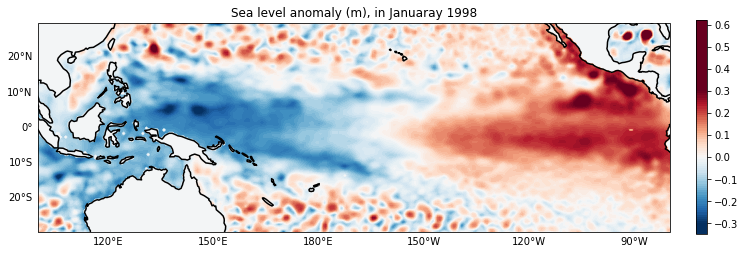

In [22]:
#Plot the sea level anomaly for Jan 1998 (month #60)
fig = plt.figure(figsize=(12,6))
projection = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=projection)
ax.add_feature(cfeature.COASTLINE, linestyle='-',lw=1.5)
ax.set_extent((100, 280, -29.75, 29.75), crs=ccrs.PlateCarree())
gl=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.xlines = False
gl.ylines = False
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150,-120, -90])
gl.xformatter = LONGITUDE_FORMATTER
im=plt.contourf(lon, lat, sla[60,::-1,:], 100,transform=ccrs.PlateCarree(),vmin=-0.3,vmax=+0.3,cmap=plt.cm.RdBu_r)
plt.colorbar(im,fraction=0.016, pad=0.04)
ax.set_title(r'Sea level anomaly (m), in Januaray 1998')

# EOF

In [3]:
#Reshape the grid to a 2-D matrix with the rows corresponding to time and columns to position 
X = np.reshape(sla, (sla.shape[0], len(lat) * len(lon)), order='F')
print("Size of X:",X.shape)
### Work with the transpose of the matrix to avoid memory problems when computing the covariance matrix
X=X.T
#Subtract the column mean 
meandata = (X.mean(axis=0))
X = X - meandata
### compute the covariance matrix as the product of X^T and X
covdat = np.dot(X.T,X)/ (nt-1)
### check size of the covariance matrix
print("Size of covariance matrix:",covdat.shape)
# we use trace() function used to Sum along diagonals.
result =  np.trace(covdat)
print("Total variance of data:",result)


Size of X: (329, 43320)
Size of covariance matrix: (329, 329)
Total variance of data: 164.23506900668144


In [4]:
### compute the eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(covdat)

### sort the eigenvalues
isort = np.argsort(vals)[::-1]
vals = vals[isort]
PCs = vecs[:, isort] # re-arrange the columns
### print first 10 eigenvalues
###  the explained variance fractions of the first 10 modes were printed, not the eigenvalues).
print("Eigenvalues are:\n", vals[0:10])
### check if sum of eigenvalues equals total variance in covariance matrix
print("Eigenvalues are:\n", sum(vals))

Eigenvalues are:
 [44.99112   10.65868    7.9184966  3.91158    3.3453305  2.608601
  2.2134578  1.8150438  1.7483413  1.5295169]
Eigenvalues are:
 164.2350698281287


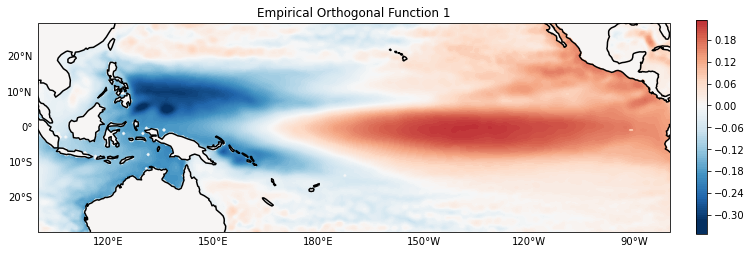

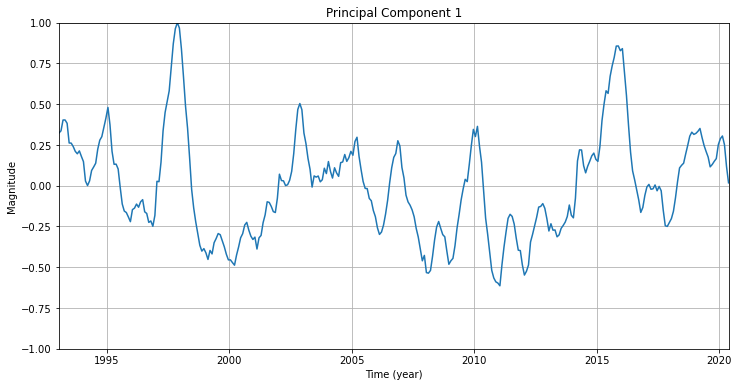

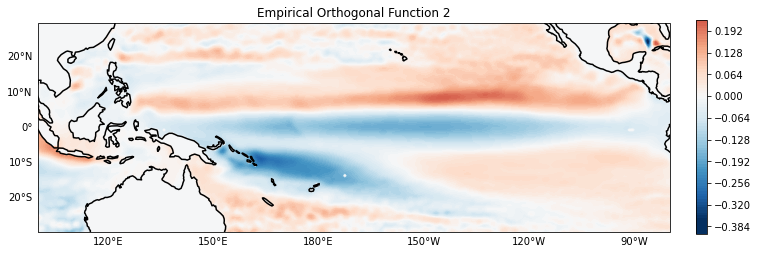

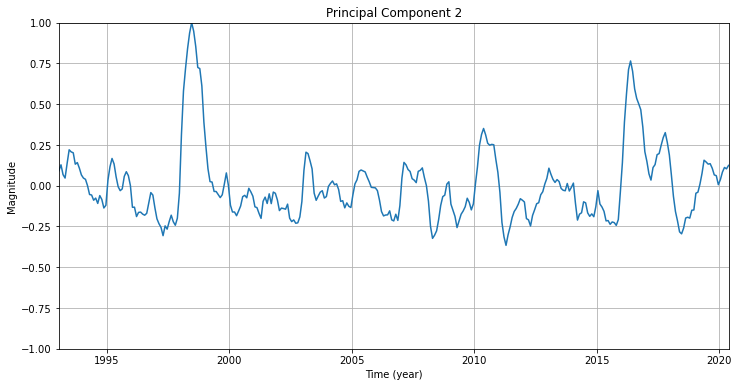

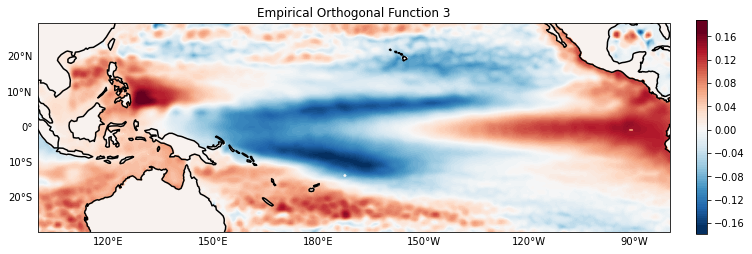

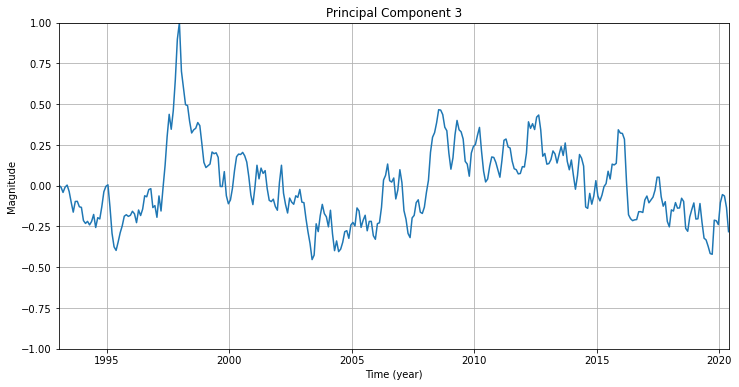

In [16]:
t = np.linspace(0, 1, nt)
EOFs = np.dot(X,vecs)  # projection on new basis
### rearrange the loadings back to lat x lon array
EOF_recons =np.reshape(EOFs.T, (nt, len(lat), len(lon)), order='F')
#### plot loadings and scores
for j in range(0,3):
    scaled_EOF = EOF_recons[j,:,:]*max(abs(PCs[:,j]))
    fig = plt.figure(figsize=(12,6))
    #fig1, ax = plt.subplots(1,1,figsize=(12,6))
    #im = ax[0].imshow(scaled_EOF, vmin=-0.9*np.amax(abs(scaled_EOF)), vmax = 0.9*np.amax(abs(scaled_EOF)), cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])
    #cbar=plt.colorbar(im,fraction=0.016, pad=0.04,ax=ax[0])
    #cbar.set_label('(m)')
    #ax[0].set_xlabel(r'Longitude ($^\circ$E)')
    #ax[0].set_ylabel(r'Latitude ($^\circ$N)')
    projection = ccrs.PlateCarree(central_longitude=180)
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.COASTLINE, linestyle='-',lw=1.5)
    ax.set_extent((100, 280, -29.75, 29.75), crs=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    gl.xlines = False
    gl.ylines = False
    gl.xlabels_top = False
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([120, 150, 180, -150,-120, -90])
    gl.xformatter = LONGITUDE_FORMATTER
    
    
    im=plt.contourf(lon, lat, scaled_EOF[::-1,:], 100,transform=ccrs.PlateCarree(),vmin=-0.9*np.amax(abs(scaled_EOF)), vmax = 0.9*np.amax(abs(scaled_EOF)),cmap=plt.cm.RdBu_r)
    cbar=plt.colorbar(im,fraction=0.016, pad=0.04)
    #cbar.set_label('Principal Component Loadings ') #rotation=270)
    eof=j+1
    ax.set_title(r'Empirical Orthogonal Function %i' % eof)
    fig2, ax1 = plt.subplots(1,1,figsize=(12,6))
    PCnor=PCs[:,j]/max(abs(PCs[:,j]))
    ax1.plot(time,PCnor)
    ax1.grid()
    ax1.set_title('Principal Component %i' % eof)
    ax1.set_xlabel('Time (year)')
    ax1.set_ylabel('Magnitude')
    ax1.set_xlim([time[0],time[-1]])
    ax1.set_ylim([-1,1])
    plt.savefig(filepath+"EOFandPC %i.png" % eof, bbox_inches='tight')
    plt.show()

# a plot of the variance explained by the eigenmodes

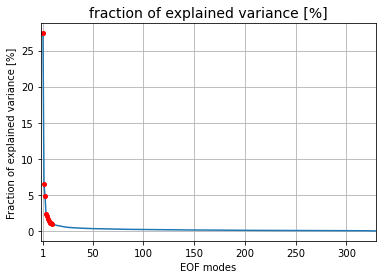

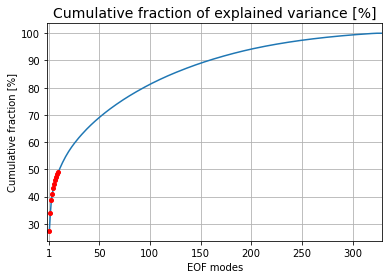

Variance contained in first 60 EOFs:   72.25


In [6]:
#Plot the cumulative fraction of explained variance of all modes
eofnumber=np.arange(1,len(vals)+1)
variance_expl=vals/np.sum(vals)*100
f, ax = plt.subplots(figsize=(6,4))
ax.plot(eofnumber,variance_expl)
ax.plot(eofnumber[0:10],variance_expl[0:10],'ro',markersize=4)
ax.set_xlabel('EOF modes')
ax.set_ylabel('Fraction of explained variance [%]')
ax.set_title("fraction of explained variance [%]", fontsize=14)
ax.grid()
ax.set_xlim([-1,nt])
ax.set_xticks([1,50,100,150,200,250,300])
#plt.savefig(filepath+"cumulativefraction.png", bbox_inches='tight')
plt.show()

#Plot the cumulative fraction of explained variance of all modes
eofnumber=np.arange(1,len(vals)+1)
variancecumsum=np.cumsum(vals)/np.sum(vals)*100
f, ax = plt.subplots(figsize=(6,4))
ax.plot(eofnumber,variancecumsum)
ax.plot(eofnumber[0:10],variancecumsum[0:10],'ro',markersize=4)
ax.set_xlabel('EOF modes')
ax.set_ylabel('Cumulative fraction [%]')
ax.set_title("Cumulative fraction of explained variance [%]", fontsize=14)
ax.grid()
ax.set_xlim([-1,nt])
ax.set_xticks([1,50,100,150,200,250,300])
#plt.savefig(filepath+"cumulativefraction.png", bbox_inches='tight')
plt.show()

print("Variance contained in first 60 EOFs:  % .2f" % variancecumsum[60])

# reconstructed data with the first 60 modes

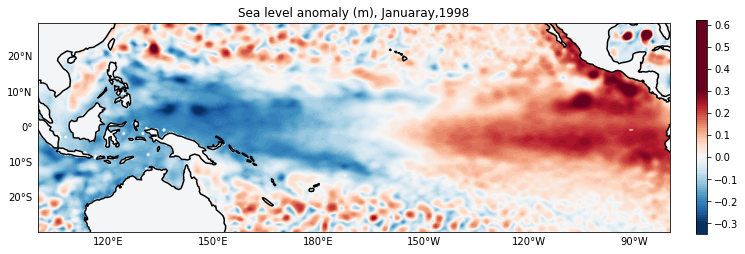

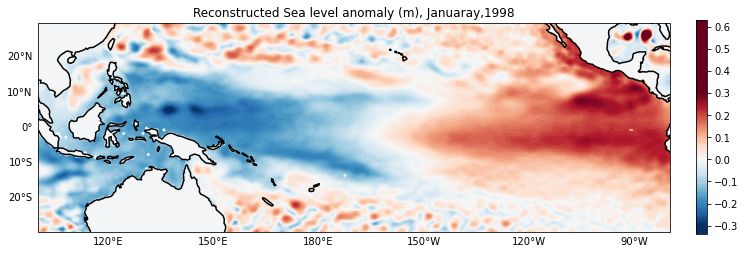

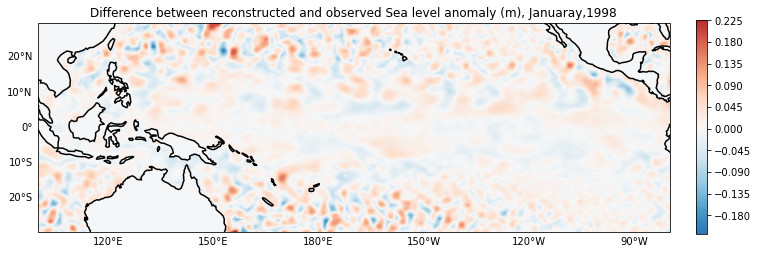

In [21]:
rebuild=np.dot(vecs[:,0:60],EOFs.T[0:60,:])
rebuild=rebuild.T+meandata.T
rebuild =np.reshape(rebuild.T, (nt, len(lat), len(lon)), order='F')

#Plot the sla Anomaly for Jan 1998
fig = plt.figure(figsize=(12,6))
projection = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=projection)
ax.add_feature(cfeature.COASTLINE, linestyle='-',lw=1.5)
ax.set_extent((100, 280, -29.75, 29.75), crs=ccrs.PlateCarree())
gl=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.xlines = False
gl.ylines = False
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150,-120, -90])
gl.xformatter = LONGITUDE_FORMATTER
im=plt.contourf(lon, lat, sla[60,::-1,:], 100,transform=ccrs.PlateCarree(),vmin=-0.3,vmax=+0.3,cmap=plt.cm.RdBu_r)
cbar=plt.colorbar(im,fraction=0.016, pad=0.04)
#cbar.set_label('Principal Component Loadings ') 
ax.set_xlabel(r'Longitude ($^\circ$E)')
ax.set_ylabel(r'Latitude ($^\circ$N)')
ax.set_title(r'Sea level anomaly (m), Januaray,1998')

#Plot the reconstructed sla Anomaly for Jan 1998
fig2 = plt.figure(figsize=(12,6))
projection = ccrs.PlateCarree(central_longitude=180)
ax2 = plt.axes(projection=projection)
ax2.add_feature(cfeature.COASTLINE, linestyle='-',lw=1.5)
ax2.set_extent((100, 280, -29.75, 29.75), crs=ccrs.PlateCarree())
gl=ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.xlines = False
gl.ylines = False
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150,-120, -90])
gl.xformatter = LONGITUDE_FORMATTER
im=plt.contourf(lon, lat,rebuild[60,::-1,:], 100,transform=ccrs.PlateCarree(),vmin=-0.3,vmax=+0.3,cmap=plt.cm.RdBu_r)
cbar=plt.colorbar(im,fraction=0.016, pad=0.04)
#cbar.set_label('Principal Component Loadings ') #rotation=270)
ax2.set_xlabel(r'Longitude ($^\circ$E)')
ax2.set_ylabel(r'Latitude ($^\circ$N)')
ax2.set_title(r'Reconstructed Sea level anomaly (m), Januaray,1998')

#Plot the difference between rebuildtructed and observed for Jan 1998
difference=rebuild[60,::-1,:]-sla[60,::-1,:]
fig3 = plt.figure(figsize=(12,6))
projection = ccrs.PlateCarree(central_longitude=180)
ax3 = plt.axes(projection=projection)
ax3.add_feature(cfeature.COASTLINE, linestyle='-',lw=1.5)
ax3.set_extent((100, 280, -29.75, 29.75), crs=ccrs.PlateCarree())
gl=ax3.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.xlines = False
gl.ylines = False
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150,-120, -90])
gl.xformatter = LONGITUDE_FORMATTER
im=plt.contourf(lon, lat, difference, 100,transform=ccrs.PlateCarree(),vmin=-0.3,vmax=+0.3,cmap=plt.cm.RdBu_r)
cbar=plt.colorbar(im,fraction=0.016, pad=0.04)
#cbar.set_label('Principal Component Loadings ') #rotation=270)
ax3.set_xlabel(r'Longitude ($^\circ$E)')
ax3.set_ylabel(r'Latitude ($^\circ$N)')
ax3.set_title(r'Difference between reconstructed and observed Sea level anomaly (m), Januaray,1998')
#plt.savefig(filepath+"Differences_sla_Jan1998.png",bbox_inches='tight')
plt.show()

# a map showing the standard deviation of the signal, and discuss this.

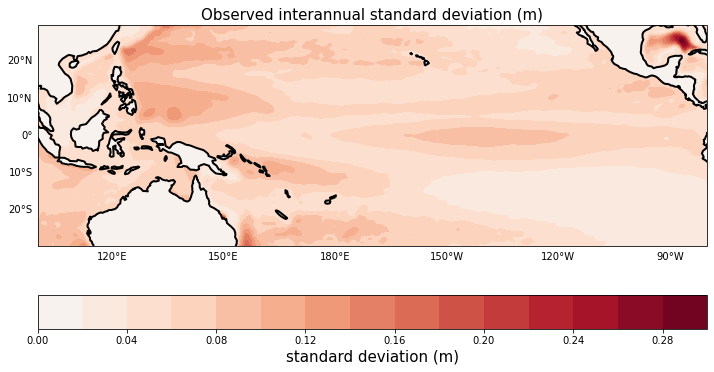

In [8]:
ds = xr.open_dataset(filepath+"dt_pac_allsat_msla_h_y1993_2020_05deg_detrended.nc")
std=ds['sla'].std(dim='time')
fig = plt.figure(figsize=(12,6))
projection = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=projection)
ax.set_extent((100, 280, -29.75, 29.75), crs=ccrs.PlateCarree())
gl=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.xlines = False
gl.ylines = False
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150,-120, -90])
gl.xformatter = LONGITUDE_FORMATTER
im=plt.contourf(lon, lat, std, 18,transform=ccrs.PlateCarree(),vmin=-0.3,vmax=+0.3,cmap=plt.cm.RdBu_r,add_colorbar=False)
cbar=plt.colorbar(im,orientation='horizontal')
cbar.set_label('standard deviation (m)',fontsize=15) 
ax.set_title(r'Observed interannual standard deviation (m)',fontsize=15)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linestyle='-',lw=2)

#  a map of the standard deviation of the reconstructed data set

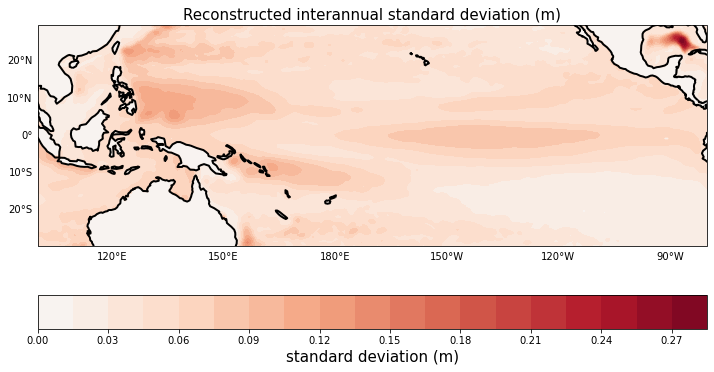

In [9]:
std_re=np.std(rebuild[:,::-1,:], axis=0)
fig = plt.figure(figsize=(12,6))
projection = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=projection)
ax.set_extent((100, 280, -29.75, 29.75), crs=ccrs.PlateCarree())
gl=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.xlines = False
gl.ylines = False
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150,-120, -90])
gl.xformatter = LONGITUDE_FORMATTER
#plt.imshow(std,vmin=-0.3,vmax=+0.3, cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
im=plt.contourf(lon, lat, std_re, 18,transform=ccrs.PlateCarree(),vmin=-0.3,vmax=+0.3,cmap=plt.cm.RdBu_r,add_colorbar=False)
cbar=plt.colorbar(im,orientation='horizontal')
cbar.set_label('standard deviation (m)',fontsize=15) 
ax.set_title(r'Reconstructed interannual standard deviation (m)',fontsize=15)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linestyle='-',lw=2)

# correlation analysis (annual averages)

In [10]:
#1993-2020
import pandas as pd
nino3=pd.read_table('./nino34.txt',sep='\t',header=None)
nino3.columns=['time']
nino3['index']=nino3['time']
for i in range(len(nino3)):
    coordinate=nino3['time'][i].split()
    nino3['time'][i]=coordinate[0]
    nino3['index'][i]=coordinate[1]
df_index=pd.date_range(start='1870-01-01',freq='MS',periods=1812)
nino3.set_index(df_index,inplace=True)
df=nino3['1993':'2020-5']
df['index'] = df['index'].astype(float)
df=df.drop(['time'], axis=1)

In [11]:
df_annual_means = df.groupby(by=df.index.year).mean()

In [12]:
df_pc_index=pd.date_range(start='1993-01-01',freq='MS',periods=329)
df_pc = pd.DataFrame(data=PCs[:,0]/max(abs(PCs[:,0])),  # EOF1 coefficients
                  index=df.index,
                  columns=['PCnor']) # specify column names
df_pc_annual_means = df_pc.groupby(by=df_pc.index.year).mean()

In [13]:
x=df_annual_means['index'].values
y=df_pc_annual_means['PCnor'].values

In [14]:
np.corrcoef(x, y)

array([[1.        , 0.94344321],
       [0.94344321, 1.        ]])

Text(0.5, 1.0, 'Correlation between EOF1 coefficient and climate indice')

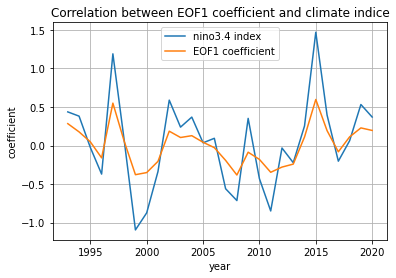

In [15]:
xaxis=np.arange(1993,2021)
plt.plot(xaxis,df_annual_means,label="nino3.4 index")
plt.plot(xaxis,df_pc_annual_means['PCnor'].values,label="EOF1 coefficient")
plt.legend()
plt.grid()
plt.xlabel("year")
plt.ylabel("coefficient")
plt.title("Correlation between EOF1 coefficient and climate indice")